### 二、数据处理与模型拟合

现在我们已经建立好了一个因子库,以这里的data.csv文件为例,我们根据原数据从各个方面一下子计算了50个因子,可以进行下一步的模型拟合.对于众多的因子,我们可以直接使用OLS来拟合,直接全部扔进去计算;也可以使用XGB或LGB等机器学习方法来进行拟合,这样就可以挖掘到因子之间潜在的关系.为了进行拟合,我们首先需要考虑:

1.对数据进行一些简单处理;

2.异常值检测;

3.确定拟合方式及参数;

4.验证拟合效果.

In [1]:
# 引入需要的包

import pandas as pd
# import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
# data.csv在price.csv的基础上计算了50个特征(因子).
dataset = pd.read_csv('data.csv')
dataset.head()

,Time,open,high,low,close,volume,money,open_interest,feature0,feature1,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,label_y
0,2019-01-02 09:01:00,11087.890,11102.522,11058.910,11086.725,5998.0,677275760.0,268956,0,-0.000105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02 09:02:00,11085.447,11098.557,11083.997,11085.915,1858.0,209742220.0,269140,1,-0.000178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-02 09:03:00,11082.769,11084.326,11047.499,11047.733,3696.0,416132420.0,269534,2,-0.003622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-02 09:04:00,11048.676,11054.233,11021.453,11032.088,4988.0,558616660.0,270420,3,-0.005033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-02 09:05:00,11033.408,11034.207,11010.193,11030.349,4250.0,477031180.0,271370,4,-0.005190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### A.数据预处理

由于因子计算时的滑动窗口及其本身的统计误差等原因,以上数据表存在一定的缺失,需要对其进行预处理.我们先对因子列的数据缺失程度进行统计,可以看到缺失幅度不超过0.1%.首先,对于数据表开头由于滑动窗口造成的因子值缺失,我们可以简单地drop掉,对于其他的因子缺失,为了避免未来数据的引入,直接采用前向填充.

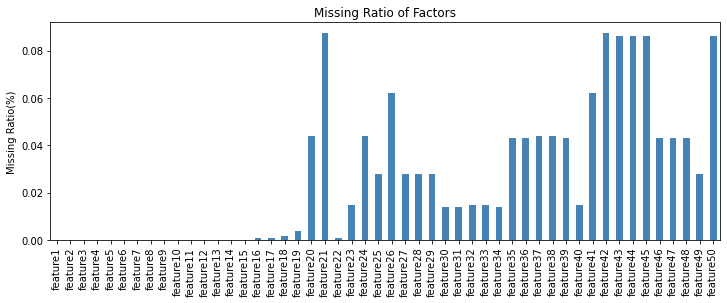

In [3]:
# 选取因子列
factor_cols = [f'feature{i}' for i in range(1, 51)]
factor_data = dataset[factor_cols]

# 缺失比例统计
missing_ratio = factor_data.isna().mean() *100
plt.figure(figsize=(12,4))
missing_ratio.plot(kind='bar', color='steelblue')
plt.title("Missing Ratio of Factors")
plt.ylabel("Missing Ratio(%)")
plt.show()

In [ ]:
# 可以看到这里的缺失值比例最大不超过0.1%

In [4]:
# 识别并删除滑动窗口开头的缺失行
first_valid_index = factor_data.apply(lambda col: col.first_valid_index())
start_index = max(first_valid_index)  # 所有因子中最晚的起始有效行
print(start_index)
dataset = dataset.loc[start_index:].reset_index(drop=True)
dataset

120


,Time,open,high,low,close,volume,money,open_interest,feature0,feature1,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,label_y
0,2019-01-02 11:16:00,10859.713,10873.208,10857.373,10873.056,930.0,103571780.0,286572,120,-0.019376,...,-4.870359,8.167203,1.077293,0.748148,0.012000,0.011766,0.061454,0.673788,0.611743,-0.194386
1,2019-01-02 11:17:00,10874.017,10875.607,10864.850,10864.850,1136.0,125658880.0,286530,121,-0.020116,...,-5.238569,8.244309,1.062713,0.686693,0.012000,0.014198,0.062599,0.657608,0.577609,-0.152343
2,2019-01-02 11:18:00,10866.166,10872.517,10864.839,10870.396,614.0,68581800.0,286454,122,-0.019615,...,-4.289645,8.371498,1.043587,0.644318,0.012000,0.007729,0.060651,0.647241,0.548000,-0.178109
3,2019-01-02 11:19:00,10871.071,10871.923,10866.060,10868.616,584.0,64768840.0,286570,123,-0.019776,...,-4.008695,8.530833,1.018967,0.616075,0.012000,0.007417,0.053867,0.681828,0.523570,-0.174633
4,2019-01-02 11:20:00,10869.741,10885.175,10868.001,10884.381,1702.0,187974480.0,286190,124,-0.018354,...,-3.647575,8.711123,0.988069,0.591106,0.012000,0.021290,0.062355,0.722894,0.504529,-0.277636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136900,2021-07-06 14:56:00,6266.018,6272.146,6265.348,6270.119,1529.0,96064600.0,420990,220,-0.004691,...,-1.177638,1.164872,0.367305,0.399501,0.003658,0.041929,0.144141,-0.136511,0.548138,NaN
136901,2021-07-06 14:57:00,6269.941,6273.775,6269.280,6271.500,1215.0,76348540.0,421118,221,-0.004472,...,-1.815561,1.158302,0.366847,0.398356,0.003658,0.032615,0.154820,-0.199227,0.530369,NaN
136902,2021-07-06 14:58:00,6271.326,6275.075,6271.326,6273.527,1526.0,95909110.0,420747,222,-0.004150,...,-1.205826,1.154749,0.365171,0.396454,0.003658,0.039504,0.174492,-0.259338,0.507401,NaN
136903,2021-07-06 14:59:00,6273.616,6277.373,6271.075,6276.031,1724.0,108318810.0,420526,223,-0.003752,...,0.109460,1.151491,0.362543,0.396444,0.003658,0.042888,0.192056,-0.281908,0.474671,NaN


In [5]:
# 除开头之外的缺失值采用前向填充
dataset[factor_cols] = dataset[factor_cols].ffill()
remaining_na = dataset[factor_cols].isna().sum().sum()
print(f"剩余缺失值数量: {remaining_na}")

剩余缺失值数量: 0


### B.异常值检测

一些因子的计算过程可能会产生inf值,为了实现进一步的模型拟合,需要对这些数值进行处理.仍然采取前面缺失值填充的方式进行前向填充.

In [6]:
inf_mask = np.isinf(dataset[factor_cols]).any()
print("各特征是否包含 inf:")
print(inf_mask[inf_mask])


各特征是否包含 inf:
feature1     True
feature35    True
feature36    True
feature40    True
feature41    True
feature49    True
dtype: bool


In [7]:
# 计算每列中 inf 和 -inf 的个数
inf_counts = np.isinf(dataset[factor_cols]).sum()

# 总行数
total_rows = len(dataset)

# 计算比例
inf_ratio = inf_counts / total_rows

print("各特征 inf 占比：")
print(inf_ratio[inf_ratio > 0].sort_values(ascending=False))

各特征 inf 占比：
feature49    0.000343
feature35    0.000212
feature36    0.000212
feature41    0.000212
feature1     0.000029
feature40    0.000029
dtype: float64


In [8]:
# 1. 替换 inf/-inf 为 NaN
dataset[factor_cols] = dataset[factor_cols].replace([np.inf, -np.inf], np.nan)

# 2. 使用前向填充，避免引入未来数据
dataset[factor_cols] = dataset[factor_cols].fillna(method="ffill")

### C.拟合部分

In [ ]:
# 使用XGBoost模型进行拟合

# 1. 构造目标变量
# ======================
dataset['target'] = dataset['close'].shift(-1) / dataset['close'] - 1
dataset = dataset.dropna().reset_index(drop=True)


# 2. 选择特征和标签
# ======================
X = dataset[[f'feature{i}' for i in range(1, 51)]]
y = dataset['target']

# 分别以60%, 20%, 20%划分训练、验证、测试集
n = len(dataset)
train_end = int(n * 0.6)
val_end   = int(n * 0.8)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val     = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test   = X.iloc[val_end:], y.iloc[val_end:]

# 3. XGBoost 拟合
# ======================
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    eval_metric="rmse", 
    early_stopping_rounds=20,  
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)



[0]	validation_0-rmse:0.00090	validation_1-rmse:0.00100
[1]	validation_0-rmse:0.00090	validation_1-rmse:0.00100
[2]	validation_0-rmse:0.00089	validation_1-rmse:0.00100
[3]	validation_0-rmse:0.00089	validation_1-rmse:0.00100
[4]	validation_0-rmse:0.00089	validation_1-rmse:0.00100
[5]	validation_0-rmse:0.00089	validation_1-rmse:0.00100
[6]	validation_0-rmse:0.00089	validation_1-rmse:0.00100
[7]	validation_0-rmse:0.00089	validation_1-rmse:0.00100
[8]	validation_0-rmse:0.00088	validation_1-rmse:0.00100
[9]	validation_0-rmse:0.00088	validation_1-rmse:0.00100
[10]	validation_0-rmse:0.00088	validation_1-rmse:0.00100
[11]	validation_0-rmse:0.00088	validation_1-rmse:0.00100
[12]	validation_0-rmse:0.00087	validation_1-rmse:0.00100
[13]	validation_0-rmse:0.00087	validation_1-rmse:0.00100
[14]	validation_0-rmse:0.00087	validation_1-rmse:0.00100
[15]	validation_0-rmse:0.00087	validation_1-rmse:0.00100
[16]	validation_0-rmse:0.00086	validation_1-rmse:0.00100
[17]	validation_0-rmse:0.00086	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
print("Best iteration:", xgb_model.best_iteration)
print("Best score:", xgb_model.best_score)

Best iteration: 10
Best score: 0.00099626458928358


In [14]:
# 4. 评估模型
# ======================
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"测试集 RMSE: {rmse:.6f}")

测试集 RMSE: 0.001129
